In [1]:
library(Seurat)
library(Matrix)
library(dplyr)
library(tibble)
library(viridis)
inputdir <- "./load_files/"
outputdir <- "./report/"

source("./ptime.fun.v2.R")

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/Co

In [2]:
## Genearte region order based on expression
load(file = paste0(inputdir, "Smooth_by_region_tRG.Rdata"))  ##trg_smt, trg_meta, 
head(trg_meta)
table(trg_meta$region)

,region,pseudotime,cluster
,<chr>,<dbl>,<chr>
FC|0.533835,FC,0.533835,NEP RSPO3 TEX15
FC|0.657051,FC,0.657051,NEP RSPO3 TEX15
FC|0.780267,FC,0.780267,NEP RSPO3 TEX15
FC|0.903483,FC,0.903483,NEP RSPO3 TEX15
FC|1.026699,FC,1.026699,NEP RSPO3 TEX15
FC|1.149916,FC,1.149916,NEP RSPO3 TEX15



 FC MSC OcC  TC 
100  92 100  55 

In [3]:
## Reorder trg_smt columns, put TC after OC
trg_smt_new_ord <- lapply(c("FC", "MSC", "OcC", "TC"), function(x) {
    yy <- colnames(trg_smt)[grepl(paste0("^", x, "\\|"), colnames(trg_smt))]
    return(yy)
    }) %>%
    unlist()
trg_smt <- trg_smt[, trg_smt_new_ord]
trg_meta <- trg_meta[trg_smt_new_ord, ]

In [4]:
## Load the enrichment results (will be used to order genes)
load(file = paste0(inputdir, "Region_DEGs_res_v2.rds"))
# vrg_deg, org_deg, vrg_res, org_res, cbn_res
res_use <- vrg_res %>%
            mutate(cluster_idx = as.numeric(factor(as.character(cluster), 
                                levels = c("NEP RSPO3", "vRG HMGA2 CCND1", "vRG SAT1 STMN2", "tRG CRYAB MEST"))))
res_use$cluster_idx[res_use$cluster_idx == 1] <- 2
head(res_use)

,gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,ratio_fc,region,cluster,cluster_idx
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,PTN,8.432734e-273,1.664995,0.901,0.355,2.919328e-268,2.495890,FC,NEP RSPO3,2
2,NNAT,1.741951e-243,1.158945,0.972,0.656,6.030459e-239,1.474474,FC,NEP RSPO3,2
3,RBP1,2.959323e-227,1.359864,0.715,0.103,1.024488e-222,6.415929,FC,NEP RSPO3,2
4,LOC106993104,7.636458e-212,1.275863,0.730,0.149,2.643665e-207,4.654088,FC,NEP RSPO3,2
5,DCT,1.096613e-178,1.090968,0.492,0.002,3.796364e-174,41.833333,FC,NEP RSPO3,2
6,COL2A1,6.802023e-170,1.080551,0.606,0.090,2.354792e-165,6.160000,FC,NEP RSPO3,2


In [5]:
## Order genes based on 
## 1. clusters showing enrichment
## 2. cut time.on to bins, order by bins, then order by time
## Load Impulse Fit results to order genes
timeres <- readRDS(file = paste0(inputdir, "Order_by_EXPR_tRG_v4.rds"))
order_genes <- lapply(names(timeres), function(reg) {
    xx <- timeres[[reg]]
    maxval <- max(trg_meta$pseudotime[trg_meta$region == reg])

    xx$time.on[xx$time.on < 0] <- -0.001
    xx$time.off[xx$time.off > ceiling(maxval)] <- ceiling(maxval) + 1

    ## Add the cell type each gene enriched in
    sub_res <- res_use %>%
                filter(region == reg)
    xx$cluster_idx <- sapply(1:nrow(xx), function(idx) min(sub_res$cluster_idx[sub_res$gene == xx$gene[[idx]]])) 

    xx$start.bin <- as.numeric(cut(xx$time.on, 10))
    xx$end.bin <- as.numeric(cut(xx$time.off, 10))

    yy <- xx$gene[order(xx$cluster_idx, 
                        xx$start.bin, 
                        xx$end.bin, 
                        xx$time.on, 
                        xx$time.off, 
                        decreasing = FALSE)]
    yy
    }) %>%
    setNames(., names(timeres)) %>%
    .[c("FC", "MSC", "OcC", "TC")]
all_visgenes <- unlist(order_genes) %>% unique()
all_visgenes

[1] "NNAT"         "MEST"         "KLHDC8A"      "SP8"          "LOC106997086"
  [6] "DUSP6"        "FZD3"         "WNT7B"        "ARL4C"        "BRINP3"      
 [11] "EXT1"         "TGIF1"        "FYN"          "BLCAP"        "CYP27A1"     
 [16] "CA4"          "ZIC5"         "TSHZ2"        "ECI2"         "WNT8B"       
 [21] "RAB11FIP2"    "ETV4"         "SPRY1"        "LGI1"         "KIAA1257"    
 [26] "RND3"         "HECW1"        "LRATD1"       "SEZ6L"        "CDC34"       
 [31] "FAT3"         "LOC106997082" "RPL3.1"       "LITAF"        "LRRC3B"      
 [36] "MSRB2"        "COL9A3"       "COL2A1"       "GYPC"         "RBP1"        
 [41] "ADAMTS19"     "FBLN1"        "ZNF395"       "ZIC4"         "CAMK4"       
 [46] "FSCN1"        "PAICS"        "RCOR2"        "MDM1"         "EFNA5"       
 [51] "PPP1R14B"     "FAM171A2"     "KHDRBS3"      "ZFPM1"        "BCL7C"       
 [56] "MEIS3"        "PHC2"         "ABHD17A"      "BOD1"         "LRP3"        
 [61] "ZNF219"       "LFNG"         "HES4"         "HES5"         "LOC100499503"
 [66] "LOC708725"    "EMX1"         "GPR27"        "DIPK1B"       "ACVR2B"      
 [71] "GLRX5"        "AKT1"         "LOC109910387" "PDLIM1"       "LOC114674534"
 [76] "MAPK11"       "PRXL2A"       "BCAT1"        "CNTNAP2"      "E2F1"        
 [81] "CNIH2"        "HMGA1"        "CDT1"         "VEGFB"        "LOC693820"   
 [86] "SNRNP200"     "ALYREF"       "SH3BP1"       "ZIC2"         "PPP1R1A"     
 [91] "PGM1"         "SAMD1"        "EXOC6"        "NT5DC2"       "HS6ST2"      
 [96] "NR2F6"        "IDH2"         "ALDH7A1"      "PPFIBP2"      "TMPO"        
[101] "BOD1L1"       "GAS6"         "UBTF"         "HIST1H1B"     "RRM2"        
[106] "HIST2H2AC"    "HIST1H1D"     "AK3"          "NAV1"         "GAS1"        
[111] "HIST1H1E"     "CBX5"         "AIF1L"        "SMC1A"        "LOC696005"   
[116] "CYP26A1"      "ZNF775"       "MAPK12"       "EVL"          "URI1"        
[121] "CDKAL1"       "EIF5A"        "ROBO1"        "TNRC18"       "CLIC4"       
[126] "SEC11C"       "SAFB"         "PRTFDC1"      "EMP2"         "EFNB2"       
[131] "ALKBH7"       "SPINK2"       "PPP2R2B"      "FBXW7"        "CD81"        
[136] "EFNB1"        "FAM181B"      "FOXG1"        "DNAJC7"       "SPRY2"       
[141] "MYO10"        "SIPA1L2"      "ENHO"         "DAB1"         "IGFBPL1"     
[146] "REEP1"        "SOX1"         "BICD1"        "DCT"          "ZIC1"        
[151] "ZIC3"         "MAP2"         "FAM171B"      "APC"          "MYO1B"       
[156] "SOCS2"        "ACTN1"        "ST8SIA1"      "TMEM163"      "PLEKHA5"     
[161] "SSBP4"        "NUTF2"        "MIS18BP1"     "METRN"        "POU3F3"      
[166] "NKAIN3"       "PAX6"         "ETV5"         "SYNM"         "SFRP1"       
[171] "TPM1"         "NFYB"         "LOC106993104" "PTN"          "CXXC5"       
[176] "LOC114671890" "SOX21"        "HSPB1"        "SLC1A3"       "TUBB2B.1"    
[181] "DOK5"         "HOPX"         "FGFBP3"       "LOC707085"    "SAT1"        
[186] "ZFHX4"        "KCTD6"        "HTRA1"        "MPPED2"       "LOC106993508"
[191] "ADGRL2"       "S100A13"      "LOX"          "DKK3"         "AP1S2"       
[196] "SCRN1"        "INTU"         "SCHIP1"       "ETV1"         "TSPAN5"      
[201] "LOC106995245" "ID2"          "OLFM2"        "CHST10"       "RSRP1"       
[206] "FABP7"        "RGMA"         "SPHK1"        "ATP1A2"       "NFIC"        
[211] "CHL1"         "HEG1"         "AK1"          "IL17RD"       "ATP6"        
[216] "SLC35F1"      "LTBP1"        "BOC"          "IRF2BPL"      "CDON"        
[221] "NCAN"         "GNG12"        "ANOS1"        "JUN"          "PALLD"       
[226] "LRATD2"       "NEK6"         "PARP8"        "PENK"         "DPYSL3"      
[231] "DIRAS3"       "CYBA"         "RARRES2"      "S100A10"      "STOX2"       
[236] "FOS"          "JUND"         "KCNA3"        "CTNNBIP1"     "LY6H"        
[241] "PDLIM4"       "BNIP3"        "FZD2"         "NRCAM"        "PMP22"       
[246] "RAI14"        "POU3F2"    

In [6]:
## Generate scaled average expression & change row names
trg_svg <- trg_smt[all_visgenes, ] %>%
            as.matrix() %>%
            t() %>% scale() %>% t() %>%
            MinMax(., min = -1.5, max = 2.5)
trg_svg[is.na(trg_svg)] <- -1.5
exp_mat <- lapply(names(order_genes), function(reg) {
        mat <- as.matrix(trg_svg[order_genes[[reg]], ,drop = FALSE])
        rownames(mat) <- paste0(reg, "|", rownames(mat))
        return(mat)
        }) %>%
        do.call(rbind, .)
head(exp_mat)

,FC|0.533835,FC|0.657051,FC|0.780267,FC|0.903483,FC|1.026699,FC|1.149916,FC|1.273132,FC|1.396348,FC|1.519564,FC|1.64278,⋯,TC|11.623285,TC|11.746501,TC|11.869717,TC|11.992933,TC|12.116149,TC|12.239366,TC|12.362582,TC|12.485798,TC|12.609014,TC|12.73223
FC|NNAT,2.5,2.5,2.50000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,⋯,-0.4097303,-0.4515940,-0.4967449,-0.5454593,-0.5974497,-0.6524289,-0.7101085,-0.7702015,-0.8324202,-0.8964772
FC|MEST,2.5,2.5,2.45313,2.341202,2.231959,2.125467,2.021793,1.921005,1.823167,1.728306,⋯,-0.4215359,-0.4155819,-0.4155870,-0.4199821,-0.4292421,-0.4438420,-0.4642563,-0.4909600,-0.5244281,-0.5651353
FC|KLHDC8A,2.5,2.5,2.50000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,⋯,-0.7815395,-0.8472836,-0.9176319,-0.9930785,-1.0731477,-1.1573645,-1.2452517,-1.3363344,-1.4301366,-1.5000000
FC|SP8,2.5,2.5,2.50000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.488594,⋯,-1.4930899,-1.4536563,-1.4077940,-1.3558070,-1.2975042,-1.2326940,-1.1611867,-1.0827905,-0.9973145,-0.9045677
FC|LOC106997086,2.5,2.5,2.50000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,⋯,0.3792768,0.3964513,0.4142824,0.4323069,0.4509990,0.4708330,0.4922827,0.5158223,0.5419261,0.5710682
FC|DUSP6,2.5,2.5,2.50000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,⋯,-0.7677172,-0.7677172,-0.7677172,-0.7677172,-0.7677172,-0.7677172,-0.7677172,-0.7677172,-0.7677172,-0.7520183


In [7]:
## Label genes
## system("cp ~/project/public_data/MEME_db/custom_motif/DatabaseExtract_v_1.01.csv ../overview/load_files/")
tfs <- read.csv(file = "../overview/load_files/DatabaseExtract_v_1.01.csv", 
                stringsAsFactors = FALSE) %>%
            subset(Is.TF. == "Yes") %>%
            .$HGNC.symbol %>% 
            unique()
cus_genes <- readLines(paste0(inputdir, "genes2label.tRG.v2.txt"))
reg_genes <- lapply(c("FC", "MSC", "OcC", "TC"), function(reg) {
            interest <- cus_genes##union(tfs, cus_genes)
            if (sum(interest %in% order_genes[[reg]]) > 0){
                return(paste0(reg, "|", intersect(order_genes[[reg]], interest)))
            }
            }) %>%
            setNames(., c("FC", "MSC", "OcC", "TC")) %>%
            lapply(., function(x) setNames(sapply(strsplit(x, "|", fixed = TRUE), "[", 2), x))
sel_genes <- list(left = c(reg_genes[["FC"]][1:14], reg_genes[["MSC"]], reg_genes[["TC"]]),
            right = c(reg_genes[["FC"]][15:length(reg_genes[["FC"]])], reg_genes[["OcC"]]))

## remove HOPX in OC
sel_genes$right <- sel_genes$right[!names(sel_genes$right) %in% "OcC|HOPX"]
sel_genes

$left
     FC|SP8    FC|WNT7B     FC|ZIC5    FC|WNT8B     FC|ETV4     FC|RBP1 
      "SP8"     "WNT7B"      "ZIC5"     "WNT8B"      "ETV4"      "RBP1" 
    FC|ZIC4    FC|EFNA5    FC|MEIS3   FC|ZNF219     FC|HES5    FC|HMGA1 
     "ZIC4"     "EFNA5"     "MEIS3"    "ZNF219"      "HES5"     "HMGA1" 
    FC|ZIC2    FC|NR2F6    MSC|HEY1    MSC|SOX3    MSC|EMX2 MSC|LAMTOR3 
     "ZIC2"     "NR2F6"      "HEY1"      "SOX3"      "EMX2"   "LAMTOR3" 
  MSC|CREB5   MSC|RAB7A    MSC|DKK3     TC|PEG3    TC|NR2F1    TC|FGFR3 
    "CREB5"     "RAB7A"      "DKK3"      "PEG3"     "NR2F1"     "FGFR3" 
   TC|NR2F2    TC|RSPO3 
    "NR2F2"     "RSPO3" 

$right
FC|CYP26A1  FC|ZNF775   FC|FOXG1    FC|ZIC1    FC|ZIC3    FC|MAP2    FC|ETV5 
 "CYP26A1"   "ZNF775"    "FOXG1"     "ZIC1"     "ZIC3"     "MAP2"     "ETV5" 
    FC|PTN   FC|CXXC5   FC|SOX21    FC|HOPX    FC|DKK3    FC|ETV1   FC|FABP7 
     "PTN"    "CXXC5"    "SOX21"     "HOPX"     "DKK3"     "ETV1"    "FABP7" 
 OcC|RSPO3  OcC|FGF13    OcC|SP5   OcC|IGF2 OcC|ZBTB16  OcC|NR2F1  OcC|FGFR3 
   "RSPO3"    "FGF13"      "SP5"     "IGF2"   "ZBTB16"    "NR2F1"    "FGFR3" 
 OcC|NR2F2   OcC|HES5  OcC|FEZF1   OcC|HEY1 OcC|ZNF219 
   "NR2F2"     "HES5"    "FEZF1"     "HEY1"   "ZNF219"

[1] "FC|NNAT"         "FC|MEST"         "FC|KLHDC8A"      "FC|SP8"         
[5] "FC|LOC106997086" "FC|DUSP6"

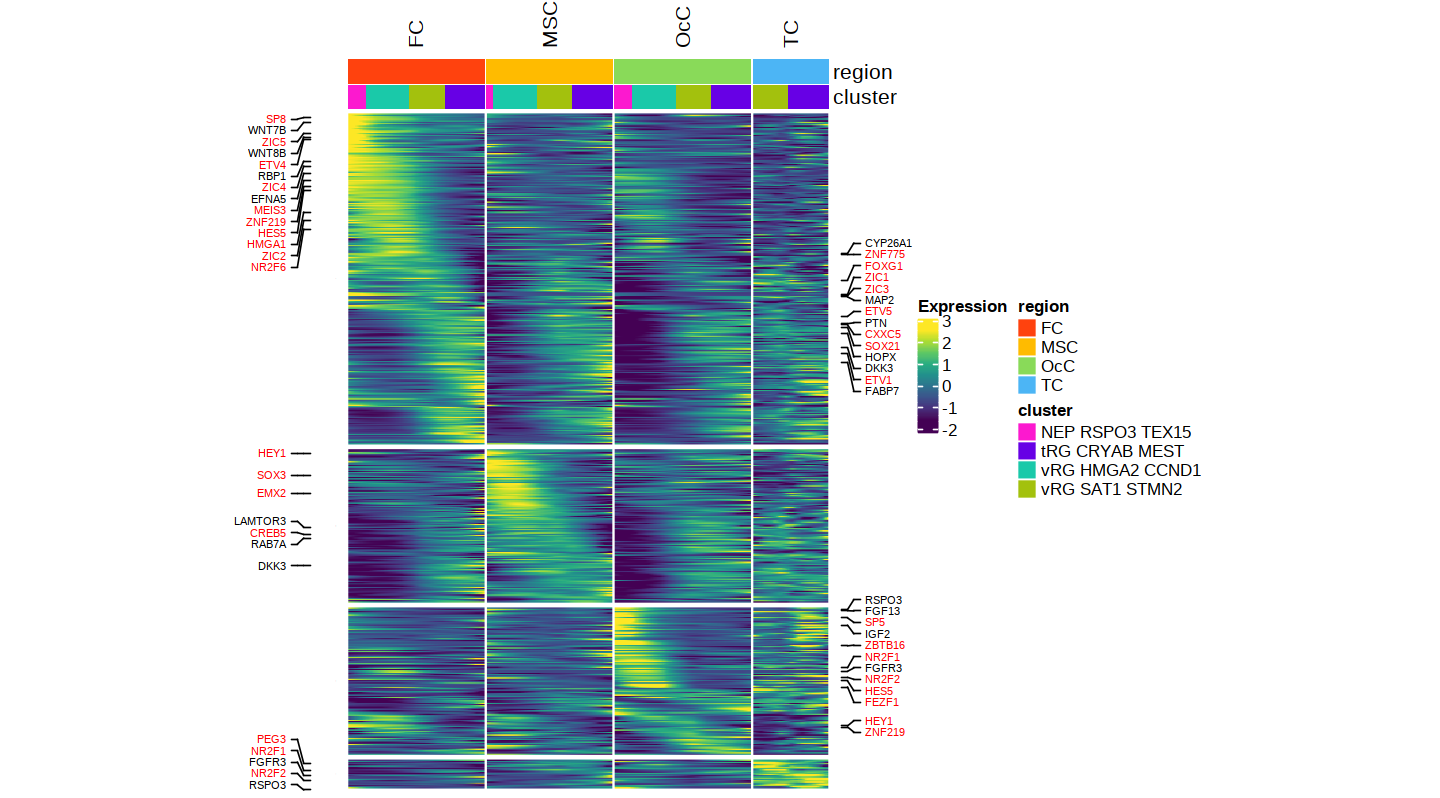

In [8]:
## Highlight TFs as red text
source("./ptime.fun.v2.R")
high_genes <- lapply(c("FC", "MSC", "OcC", "TC"), function(reg) paste0(reg, "|", tfs)) %>%
            unlist()
rsplit <- strsplit(rownames(exp_mat),"|",fixed = TRUE) %>%
            sapply(., "[", 1) %>%
            setNames(., NULL) %>%
            factor(., levels = c("FC", "MSC", "OcC", "TC"))
head(rownames(exp_mat))

## Plot
ht1 <- plot_heatmap.RGCcascade.regionshare(mat = exp_mat, 
            meta = trg_meta, 
            label_genes = sel_genes, 
            color_breaks = seq(-1.5, 2.5, 0.5), 
            file_name = paste0("Expr_byExpr_NESC-tRG_v2"), 
            pdf_height = 6, 
            row_split = rsplit, highlight_genes = high_genes, fontsize = 6)

options(repr.plot.width=12, repr.plot.height=6.65)
draw(ht1)
## the row_split parameter doesn't work well in the jupyter notebook, so the gene labels are not aligned well unless
## output it to a pdf file

In [9]:
pdf("./report/Expr_byExpr_NESC-tRG_v2.selected.pdf", width = 12, height = 7)
draw(ht1)
dev.off()

png 
  2

png 
  2

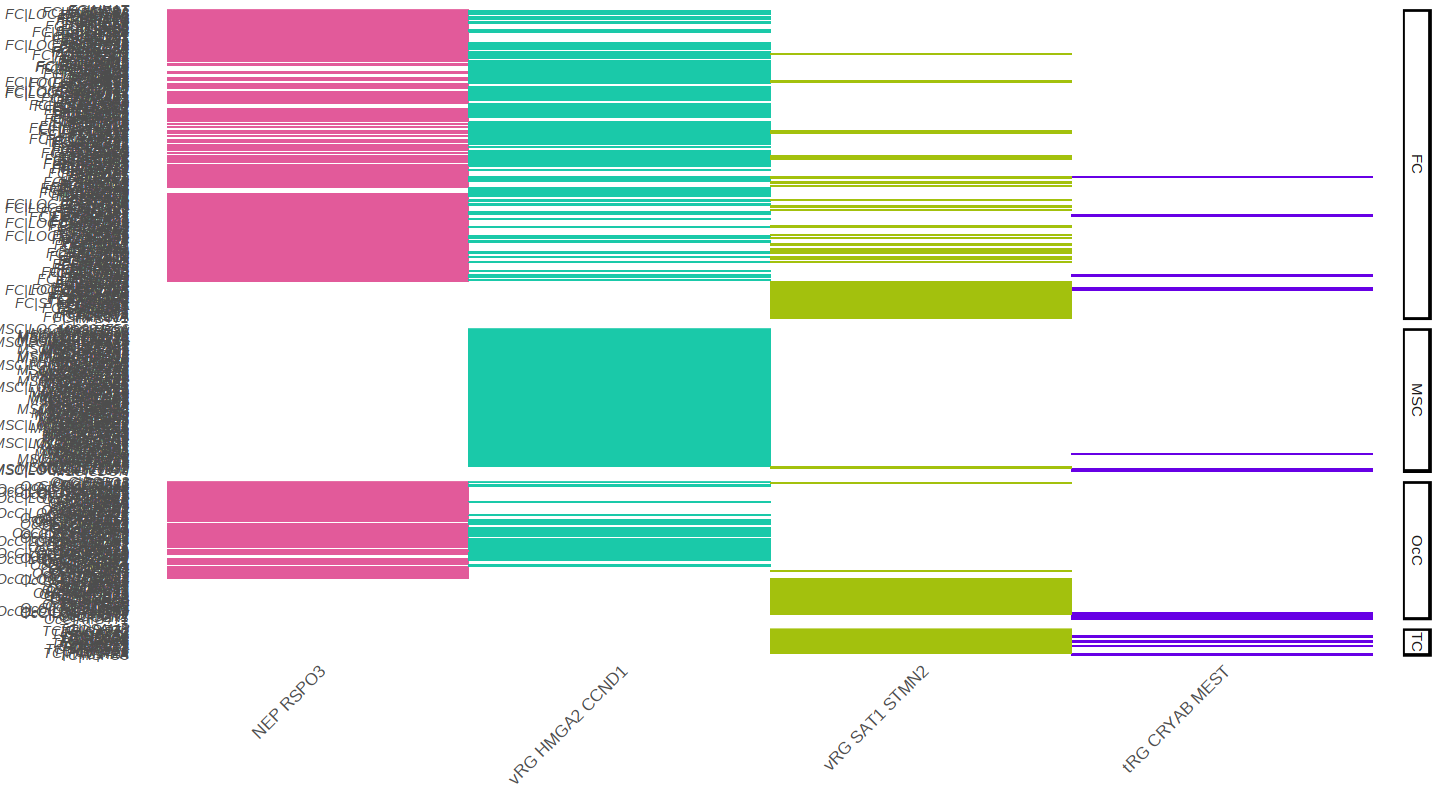

In [10]:
##------------------------------------------------------------------------------------------
## Plot annotation
#"#fc19cf", 
cls_cols <- c("#e25a9a", "#1ac9a9", "#a3c10d", 
    "#efbc88", "#dbb75c", "#6700e5", "#7133aa", "#003563"
    ) %>%
            setNames(., c("NEP RSPO3", "vRG HMGA2 CCND1", "vRG SAT1 STMN2", 
                "oRG HOPX TNC", "oRG HOPX APOE", 
                "tRG CRYAB MEST", "tRG CRYAB FNDC1", "Ependymal"))
sel_cls <- c("NEP RSPO3", "vRG HMGA2 CCND1", "vRG SAT1 STMN2", "tRG CRYAB MEST")
reggene_ord <- lapply(names(order_genes), function(reg) paste0(reg, "|", order_genes[[reg]])) %>%
                unlist()
ctp_annot <- res_use %>%
                mutate(cluster = factor(as.character(cluster), levels = sel_cls)) %>%
                mutate(reggene = paste0(region, "|", gene)) %>%
                mutate(reggene = factor(reggene, levels = rev(reggene_ord))) %>%
                mutate(region = factor(region, levels = c("FC", "MSC", "OcC", "TC"))) %>%
                mutate(fillcol = cls_cols[as.character(cluster)])
p1 <- ggplot(ctp_annot, aes_string(x = "cluster", y = "reggene", fill = "fillcol")) + 
                geom_tile(color = NA, size = 1) +
                ##scale_fill_manual(values = c(`0` = "lightgrey", `1` = "black")) +
                scale_fill_identity() +
                theme_classic() + 
                RotatedAxis() + 
                facet_grid(rows = vars(region), space = "free_y", scales = "free_y") +
                theme(axis.line = element_blank(), axis.ticks = element_blank(), 
                      axis.title = element_blank(), 
                      axis.text.y = element_text(size = 8, face = "italic"), 
                      axis.text.x = element_text(size = 10))
p1
pdf(paste0("./report/", "Expr_byExpr_NESC-tRG_v2.annot-region.pdf"), width = 4, height = 6)
print(p1)
dev.off()

In [11]:
#------------------------------------------------------------------------------------------
## Save the results as table
allcls <- c("NEP RSPO3", "vRG HMGA2 CCND1", "vRG SAT1 STMN2", "tRG CRYAB MEST")
enr_mat <- matrix(0, nrow = nrow(exp_mat), ncol = length(allcls), dimnames = list(rownames(exp_mat), allcls))
for (ii in rownames(enr_mat)){
    cls <- ctp_annot$cluster[ctp_annot$reggene %in% ii]
    if (length(cls) >= 1){
        for (jj in cls){
            enr_mat[ii, jj] <- 1
        } 
    }
}
colnames(enr_mat)[colnames(enr_mat) %in% "NEP RSPO3"] <- "NESC RSPO3"



df <- data.frame(reg_gene = rownames(exp_mat),
        stringsAsFactors = FALSE) %>%
        mutate(region = sapply(strsplit(reg_gene, "|", fixed = TRUE), "[", 1), 
               gene = sapply(strsplit(reg_gene, "|", fixed = TRUE), "[", 2)) %>%
        mutate(isTF = ifelse(gene %in% tfs, "Y", "N")) %>%
        cbind(., enr_mat)
df$time.on <- NA
df$time.off <- NA
for (ii in 1:nrow(df)){
    reg <- df$region[ii]
    gene <- df$gene[ii]
    timedata <- timeres[[reg]]

    df$time.on[ii] <- round(timedata$time.on[timedata$gene %in% gene], digits = 5)
    df$time.off[ii] <- round(timedata$time.off[timedata$gene %in% gene], digits = 5)
    if (df$time.on[ii] > df$time.off[ii]){
        df$time.off[ii] <- 100
    }
}
df$time.on <- MinMax(df$time.on, min = -100, max = 100)
df$time.off <- MinMax(df$time.off, min = 0, max = 100)

df <- df[, c("region", "gene", "isTF", colnames(enr_mat), "time.on", "time.off")]
df$region <- gsub("^FC$", "FR", df$region) %>%
        gsub("MSC", "MS", .) %>%
        gsub("TC", "Tem", .) %>%
        gsub("OcC", "OC", .)

colnames(df) <- c("Enriched region", "Gene", "is TF?", paste0("Enriched in ", colnames(enr_mat)), 
                  "Pseudotime on", "Pseudotime off")
head(df)

,Enriched region,Gene,is TF?,Enriched in NESC RSPO3,Enriched in vRG HMGA2 CCND1,Enriched in vRG SAT1 STMN2,Enriched in tRG CRYAB MEST,Pseudotime on,Pseudotime off
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FC|NNAT,FR,NNAT,N,1,0,0,0,-100,0.53383
FC|MEST,FR,MEST,N,1,1,0,0,-100,0.53383
FC|KLHDC8A,FR,KLHDC8A,N,1,1,0,0,-100,0.53383
FC|SP8,FR,SP8,Y,1,1,0,0,-100,0.53383
FC|LOC106997086,FR,LOC106997086,N,1,1,0,0,-100,0.53383
FC|DUSP6,FR,DUSP6,N,1,0,0,0,-100,0.53383


In [12]:
write.table(df, file = "./report/table_Sxx_NSC_progression_ventricular_v2.txt", 
            row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

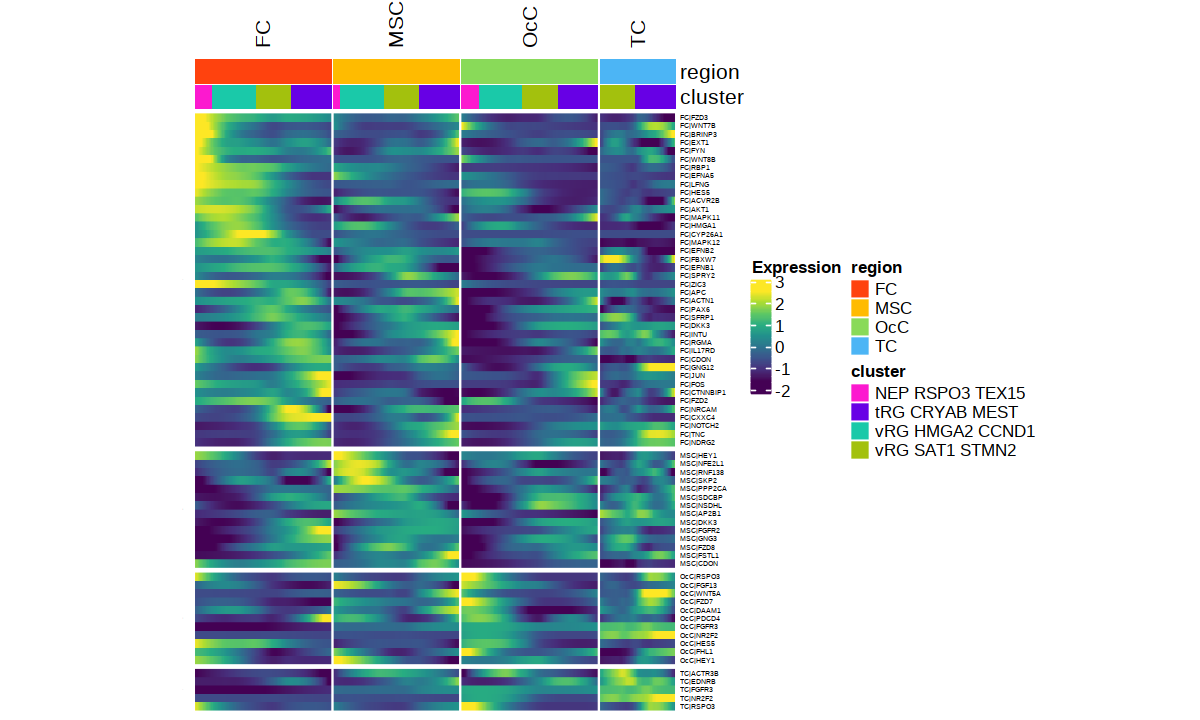

In [13]:
## Load pathway genes
## Load signaling-related genes & intersect
source("./ptime.fun.v2.R")
path_gset <- readRDS("../../MF2_organizer/overview/load_files/Pathway_updated_20221219.rds")
all_siggenes <- unlist(path_gset) %>% unique()
order_genes <- lapply(order_genes, function(x) intersect(x, all_siggenes))
all_visgenes <- unlist(order_genes) %>% unique()


## Generate scaled average expression & change row names
trg_svg <- trg_smt[all_visgenes, ,drop = FALSE] %>%
            as.matrix() %>%
            t() %>% scale() %>% t() %>%
            MinMax(., min = -1.5, max = 2.5)
trg_svg[is.na(trg_svg)] <- -1.5
exp_mat <- lapply(names(order_genes), function(reg) {
        mat <- as.matrix(trg_svg[order_genes[[reg]], ,drop = FALSE])
        rownames(mat) <- paste0(reg, "|", rownames(mat))
        return(mat)
        }) %>%
        do.call(rbind, .)

rsplit <- sapply(strsplit(rownames(exp_mat), "|", fixed = TRUE), "[", 1) %>%
            setNames(., NULL) %>%
            factor(., levels = c("FC", "MSC", "OcC", "TC"))


## Plot
ht2 <- plot_heatmap.RGCcascade(mat = exp_mat, 
                               meta = trg_meta, 
                               label_genes = NULL, 
                               color_breaks = seq(-1.5, 2.5, 0.5), 
                               file_name = paste0("Expr_byExpr_NESC-tRG_Signaling"), 
                               pdf_height = 6, 
                               row_split = rsplit, highlight_genes = NULL, fontsize = 10)
options(repr.plot.width=10, repr.plot.height=6)
draw(ht2)

In [14]:
pdf(paste0("./report/Expr_byExpr_NESC-tRG_Signaling_heatmap_v2.pdf"), width = 10, height = 6)
draw(ht2)
dev.off()

png 
  2

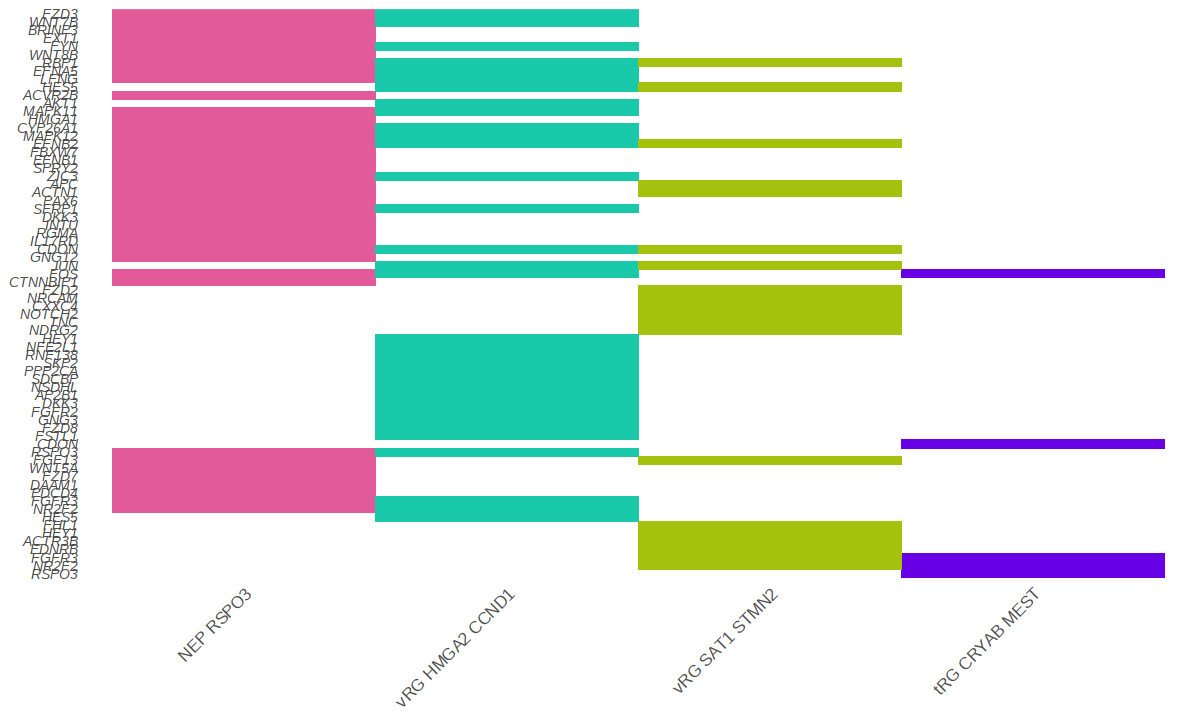

In [15]:
## Plot annotation for those signal genes
##------------------------------------------------------------------------------------------
## Plot annotation
cls_cols <- c("#e25a9a", "#1ac9a9", "#a3c10d", 
    "#efbc88", "#dbb75c", "#6700e5", "#7133aa", "#003563"
    ) %>%
            setNames(., c("NEP RSPO3", "vRG HMGA2 CCND1", "vRG SAT1 STMN2", 
                "oRG HOPX TNC", "oRG HOPX APOE", 
                "tRG CRYAB MEST", "tRG CRYAB FNDC1", "Ependymal"))
sel_cls <- c("NEP RSPO3", "vRG HMGA2 CCND1", "vRG SAT1 STMN2", "tRG CRYAB MEST")
reggene_ord <- lapply(names(order_genes), function(reg) paste0(reg, "|", order_genes[[reg]])) %>%
                unlist()
ctp_annot <- res_use %>%
                mutate(cluster = factor(as.character(cluster), levels = sel_cls)) %>%
                mutate(reggene = paste0(region, "|", gene)) %>%
                filter(reggene %in% reggene_ord) %>%
                mutate(reggene = factor(reggene, levels = rev(reggene_ord))) %>%
                mutate(region = factor(region, levels = c("FC", "MSC", "OcC", "TC"))) %>%
                mutate(fillcol = cls_cols[as.character(cluster)])
y_labels <- sapply(strsplit(rev(reggene_ord), "|", fixed = TRUE), "[", 2) %>%
                setNames(., rev(reggene_ord))
p1 <- ggplot(ctp_annot, aes_string(x = "cluster", y = "reggene", fill = "fillcol")) + 
                geom_tile(color = NA, size = 1) +
                ##scale_fill_manual(values = c(`0` = "lightgrey", `1` = "black")) +
                scale_fill_identity() +
                theme_classic() + 
                scale_y_discrete(labels = y_labels) +
                RotatedAxis() + 
                ##facet_grid(rows = vars(region), space = "free_y", scales = "free_y") +
                theme(axis.line = element_blank(), axis.ticks = element_blank(), 
                  axis.title = element_blank(), 
                  axis.text.y = element_text(size = 8, face = "italic"), 
                  axis.text.x = element_text(size = 10))
p1

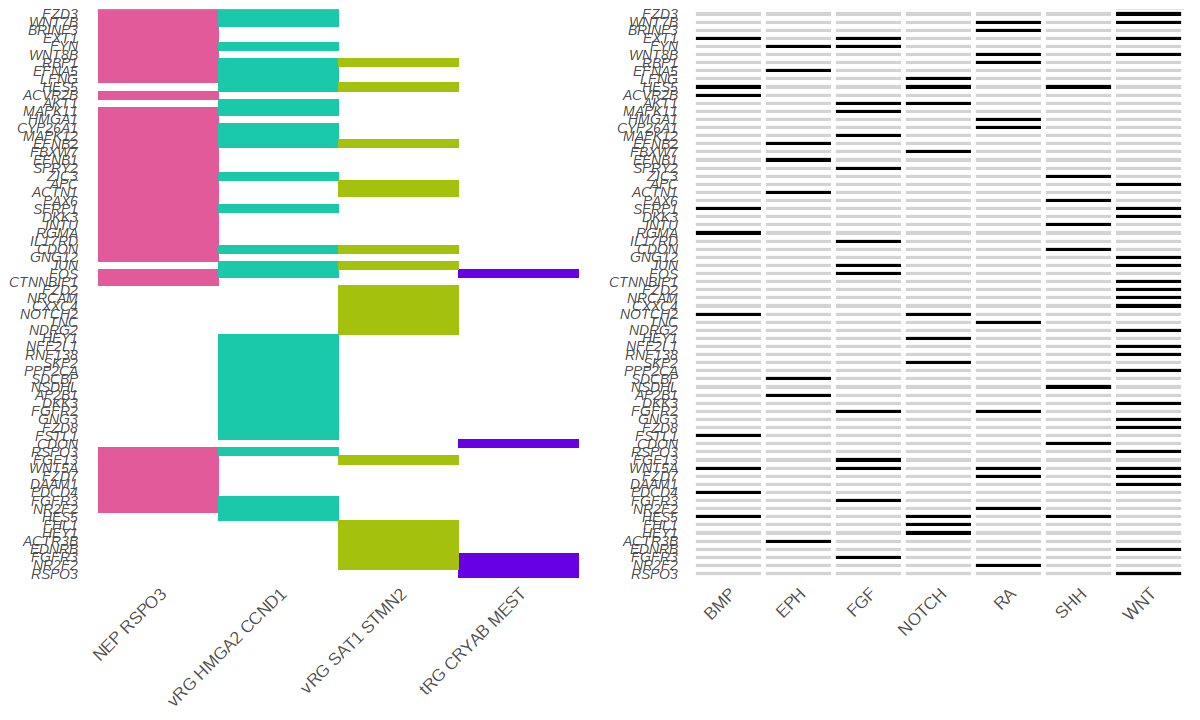

In [16]:
## Plot pathway annotation
anno_mat <- lapply(names(path_gset), function(sig) {
            genes <- sapply(strsplit(reggene_ord, "|", fixed = TRUE), "[", 2)
            value <- setNames(ifelse(genes %in% path_gset[[sig]], 1, 0), reggene_ord)
            value
            }) %>%
            setNames(., names(path_gset)) %>%
            as.data.frame(., check.names = FALSE) %>%
            rownames_to_column("reggene") %>%
            tidyr::gather(., "pathway", "value", names(path_gset)) %>%
            mutate(pathway = factor(pathway, levels = c("BMP", "EPH", "FGF", "NOTCH", "RA", "SHH", "WNT"))) %>%
            mutate(reggene = factor(reggene, levels = rev(reggene_ord))) %>%
            mutate(fillcol = ifelse(value == 1, "black", "lightgrey"))
p2 <- ggplot(anno_mat, aes_string(x = "pathway", y = "reggene", fill = "fillcol")) + 
            geom_tile(color = "white", size = 1) +
            scale_fill_identity() +
            theme_classic() + 
            scale_y_discrete(labels = y_labels) +
            RotatedAxis() + 
            ##facet_grid(rows = vars(region), space = "free_y", scales = "free_y") +
            theme(axis.line = element_blank(), 
                  axis.ticks = element_blank(), 
                  axis.title = element_blank(), 
                  axis.text.y = element_text(size = 8, face = "italic"), 
                  axis.text.x = element_text(size = 10))
panno <- cowplot::plot_grid(p1, p2, align = "h")
panno

In [17]:
pdf(paste0("./report/", "Expr_byExpr_NESC-tRG_Signaling_v2.annot-region_v2.pdf"), width = 6, height = 6)
print(panno)
dev.off()

png 
  2

In [18]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /gpfs/gibbs/pi/sestan.ycga/sm2726/Tools/Anaconda3/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] tidyr_1.1.3          ggforce_0.3.1        scatterpie_0.1.5    
 [4] ggplot2_3.3.0        ComplexHeatmap_2.2.0 circlize_0.4.13     
 [7] viridis_0.5.1        viridisLite_0.3.0    tibble_3.0.1        
[10] dplyr_1.0.7          Matrix_1.5-3     